In [ ]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing

%matplotlib inline
#%matplotlib notebook
#from pandas_profiling import ProfileReport


In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time


# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections

# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
#drive.mount("/content/sample_data")
df_bladder = pd.read_excel("/content/Clinical_trial_dataset.xlsx")
colors = ["#0101DF", "#DF0101"]
df_bladder.head(3)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,Sample,Gold Standard,Sex,Age,ISL19614,ISL18938,ISL11482,ISL7550,ISL26637,ISL8677,ISL22730,ISL6568,ISL7803,ISL9258,ISL22274,ISL361,ISL1929,ISL2504,ISL10877
0,Am008,Negative,NaN,NaN,9.300,inf,12.603,12.435,10.521,8.930,8.781,11.849,8.910,9.900,8.643,12.631,11.046,10.143,13.305
1,AM010,Negative,M,61.0,7.832,18.668,12.121,11.681,11.238,9.017,10.970,17.179,11.412,10.391,8.580,15.324,12.594,11.615,14.771
2,AM014,Negative,F,84.0,8.487,16.073,inf,11.525,9.398,9.147,9.703,11.161,7.919,9.603,10.972,10.873,11.268,10.822,12.145


In [ ]:
df_bladder.rename(columns={'Gold Standard':'ground_truth'}, inplace=True)
df_bladder['ground_truth'] = df_bladder['ground_truth'].replace({'Negative': 0, 'Positive': 1}) # replace string of negative and postive to numerical value 0 and 1
df_bladder_clean = df_bladder
#df_bladder.head()
#df_bladder.tail(3)

In [ ]:
#df_bladder.info() #data exploration

In [ ]:
#pd.isnull(df_bladder).sum()

In [ ]:
#df_bladder.groupby(['Sex']).mean()

In [ ]:
#df_bladder.groupby(['ground_truth']).value_counts()

In [ ]:
# sns.scatterplot(data=df_bladder, x="ISL19614", y="Age" )
# plt.show()

In [ ]:
# -------The classes are heavily skewed we need to solve this issue  ---------

# print('Non-Cancer', round(df_normalized['ground_truth'].value_counts()[0]/len(df_normalized) * 100,2), '% of the dataset')
# print('Cancer', round(df_normalized['ground_truth'].value_counts()[1]/len(df_normalized) * 100,2), '% of the dataset')

In [ ]:
# ------Plot the count plot of the class distribution Cancer vs Non-Cancer -----

# colors = ["#0101DF", "#DF0101"]

# sns.countplot('ground_truth', data=df_bladder, palette=colors)
# plt.title('Class Distributions \n (0: Non-Cancer || 1: Cancer)', fontsize=14)

In [ ]:
# Plot pairwise bivariate distributions with pairplot before scaling
# ... and before converting the inf to the maximum values

# sns.pairplot(df_bladder, hue='ground_truth', palette=colors, vars=['Age','ISL19614', 'ISL18938',
#        'ISL11482', 'ISL7550', 'ISL26637'])

## 1.
**Replace inf in each feature column with the maximum value of the column**

In [ ]:
# ------- Replace inf in each column with the maximum value in each column ------

df_scaled = df_bladder

df_bladder.iloc[:, 4:19] = df_bladder.iloc[:, 4:19].replace(np.inf, np.nan)
#df_bladder.head(8)


df_scaled.iloc[:, 4:19] = df_scaled.iloc[:, 4:19].apply(lambda column: column.fillna(max(column)))
#df_normalized.head(8)

# b/c column number 5 starts with inf / NaN we could not asssign the maximum value
max_col_5 = df_scaled.iloc[:, 5].max()
df_scaled['ISL18938'] = df_scaled['ISL18938'].fillna(max_col_5)
#df_scaled.head(8)

## 2. A
**Scale each feature: transform data to fit within 0-1 scale (No need to normalize because the pairplot shows normal distribution of the data)**

In [ ]:

# ------ SCALING --- transforming data to fit within 0-1 scale
min_max_scaler  = preprocessing.MinMaxScaler()

df_scaled[['ISL19614', 'ISL18938',
       'ISL11482', 'ISL7550', 'ISL26637', 'ISL8677', 'ISL22730', 'ISL6568',
       'ISL7803', 'ISL9258', 'ISL22274', 'ISL361', 'ISL1929', 'ISL2504',
       'ISL10877']] = min_max_scaler.fit_transform(df_scaled[['ISL19614', 'ISL18938',
       'ISL11482', 'ISL7550', 'ISL26637', 'ISL8677', 'ISL22730', 'ISL6568',
       'ISL7803', 'ISL9258', 'ISL22274', 'ISL361', 'ISL1929', 'ISL2504',
       'ISL10877']])
#df_scaled.head(6)


## 2. B

**Do the same as above but without changing the inf**


In [ ]:
# need to do below and use it later for PCA
#df_bladder.head()


,Sample,ground_truth,Sex,Age,ISL19614,ISL18938,ISL11482,ISL7550,ISL26637,ISL8677,ISL22730,ISL6568,ISL7803,ISL9258,ISL22274,ISL361,ISL1929,ISL2504,ISL10877
0,Am008,0,NaN,NaN,9.300,inf,12.603,12.435,10.521,8.930,8.781,11.849,8.910,9.900,8.643,12.631,11.046,10.143,13.305
1,AM010,0,M,61.0,7.832,18.668,12.121,11.681,11.238,9.017,10.970,17.179,11.412,10.391,8.580,15.324,12.594,11.615,14.771
2,AM014,0,F,84.0,8.487,16.073,inf,11.525,9.398,9.147,9.703,11.161,7.919,9.603,10.972,10.873,11.268,10.822,12.145
3,AM015,0,M,66.0,8.516,inf,13.493,12.405,9.194,10.755,10.835,12.382,10.123,10.794,9.790,inf,11.997,13.039,12.432
4,AM016,0,M,62.0,7.273,13.081,inf,11.439,9.581,7.088,9.616,10.901,7.931,8.468,8.067,10.321,10.673,8.696,9.773


In [ ]:
# plot the pairplot of the scaled features

# sns.pairplot(df_scaled, hue='ground_truth', palette=colors, vars=['Age','ISL19614', 'ISL18938',
#        'ISL11482', 'ISL7550', 'ISL26637'])

# sns.pairplot(df_scaled, hue='ground_truth', vars=['Age','ISL19614', 'ISL18938',
#        'ISL11482', 'ISL7550', 'ISL26637', 'ISL8677', 'ISL22730', 'ISL6568',
#        'ISL7803'])
# plt.show()

In [ ]:
#------ Count the infinity values: ---------
# ds = df_normalized.isin([np.inf, -np.inf]).sum()
# print(ds)

In [ ]:
#df_normalized.isnull().sum()

In [ ]:
#df_normalized.columns


# 3. Distribution of the label Cancer and non-Cancer and define the 5-fold cross validation
 See if both the train and test label distribution are similarly distributed



In [ ]:
# plot the distribution of the data
# define the cross validation
# See if both the train and test label distribution are similarly distributed

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('Non-Cancer', round(df_scaled['ground_truth'].value_counts()[0]/len(df_scaled) * 100,2), '% of the dataset')
print('Cancer', round(df_scaled['ground_truth'].value_counts()[1]/len(df_scaled) * 100,2), '% of the dataset')

X = df_scaled.drop(['Sample', 'ground_truth', 'Sex', 'Age'], axis=1)
y = df_scaled['ground_truth']

# cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.
sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    #print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]


# Turn into an array (already after scaling )
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))




Non-Cancer 92.16 % of the dataset
Cancer 7.84 % of the dataset
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.9212963 0.0787037]
[0.92260062 0.07739938]



# 4. Make balanced dataset using Downsampling of the non-cancer group

**df = scaled dataframe of size 1619x19**

Total of 127 cancer and 127 non-cancer -->  N = 254 balanced data

call it new_df

In [ ]:

# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes

# Shuffle the data before creating the subsamples

# **df = scaled and shuffled dataframe of size 1619x19**

df = df_scaled.sample(frac=1)


# amount of cancer classes 127 rows.
cancer_df = df.loc[df['ground_truth'] == 1]
non_cancer_df = df.loc[df['ground_truth'] == 0][:127]

# concantinate the groups
normal_distributed_df = pd.concat([cancer_df, non_cancer_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head(4)

,Sample,ground_truth,Sex,Age,ISL19614,ISL18938,ISL11482,ISL7550,ISL26637,ISL8677,ISL22730,ISL6568,ISL7803,ISL9258,ISL22274,ISL361,ISL1929,ISL2504,ISL10877
912,TO068 FU2,0,F,NaN,0.278588,0.420983,0.345395,0.350180,0.260212,0.206660,0.203394,0.273469,0.190128,0.289139,0.326392,0.332820,0.333239,0.364138,0.369907
24,KMC019,1,F,80.0,0.442301,0.667129,0.590753,0.394571,0.384921,0.377265,0.377331,0.431257,0.472194,0.287926,0.376031,0.585142,0.362620,0.402366,0.362776
1264,RU040,1,F,74.0,0.439085,1.000000,0.481255,0.539130,0.372398,0.423485,0.442964,0.502211,0.627715,0.391181,0.414485,0.537729,0.545888,0.473703,0.423764
466,VD391,0,M,82.0,0.436168,1.000000,0.612563,0.553255,0.430348,0.488727,0.516884,0.654161,0.456108,0.441930,0.564948,0.194783,0.688738,0.628405,0.689975


In [ ]:
# plot the distribution of the data

# print('Distribution of the Classes in the subsample dataset')
# print(new_df['ground_truth'].value_counts()/len(new_df))
# colors = ["#0101DF", "#DF0101"]
# sns.countplot('ground_truth', data=new_df, palette=colors)
# plt.title('Equally Distributed Classes', fontsize=14)
# plt.show()


##5. Correlation Matrices




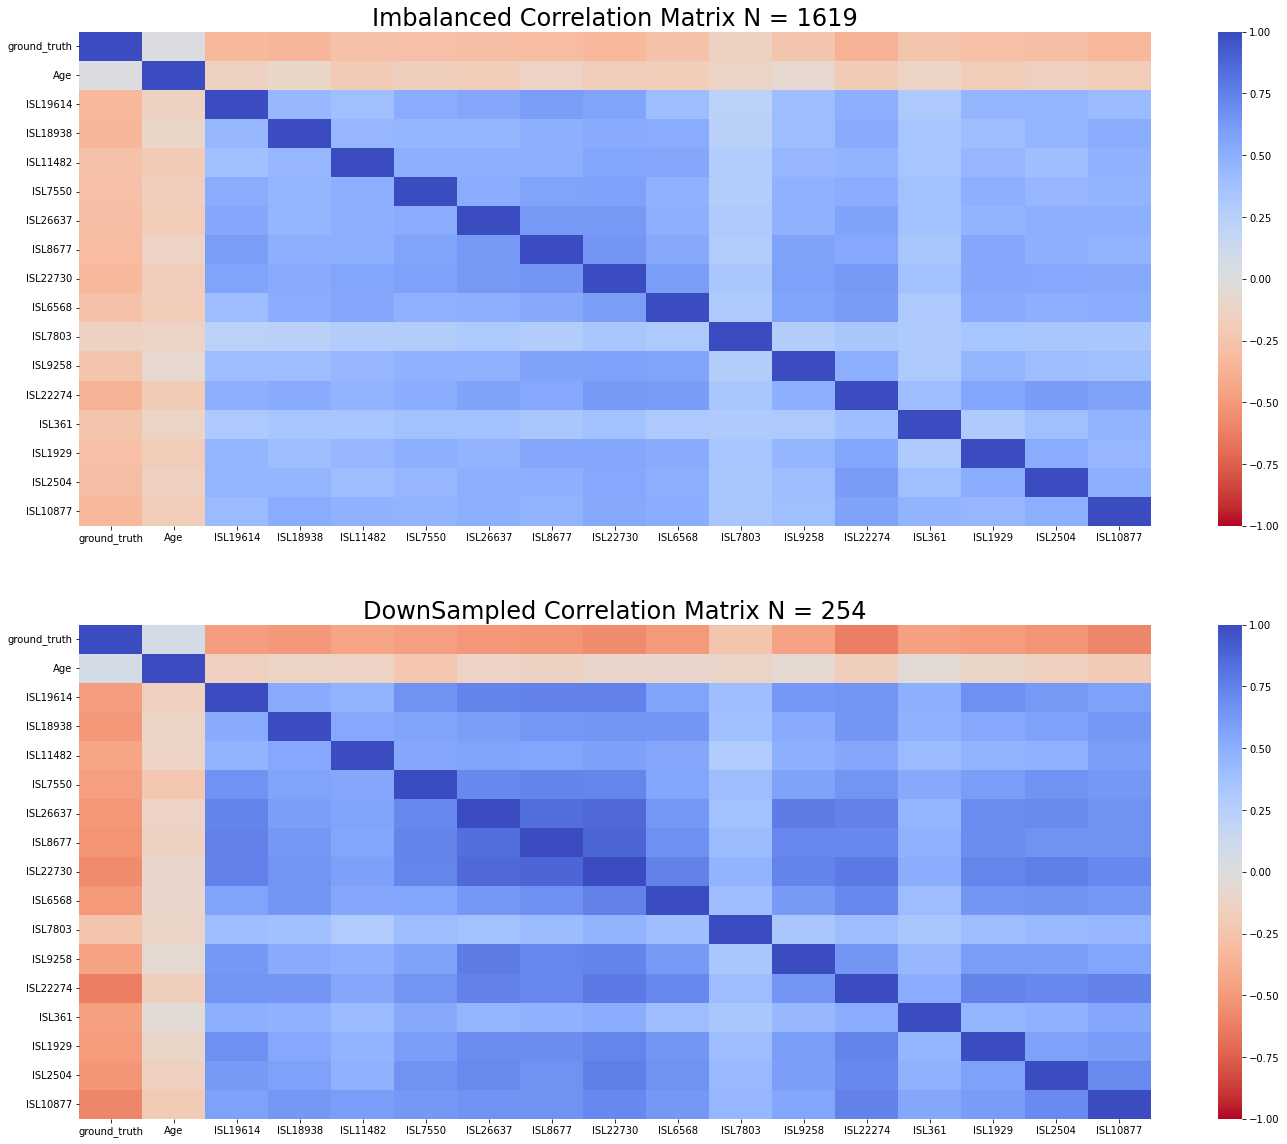

In [ ]:
# Make sure we use the subsample in our correlation

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame N = 1619
corr = df_scaled.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1, vmin=-1, vmax=1)
ax1.set_title("Imbalanced Correlation Matrix N = 1619", fontsize=24)

# Undersampled DataFrame N = 254
sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2, vmin=-1, vmax=1)
ax2.set_title('DownSampled Correlation Matrix N = 254', fontsize=24)
plt.show()

# We see Negative Correlations to the ground truth --> All features are negatively correlated. The lower the values are, the more likely cancer patient.


Text(0.5, 1.0, 'Imbalanced Correlation Matrix w/o feature engineering N = 1619')

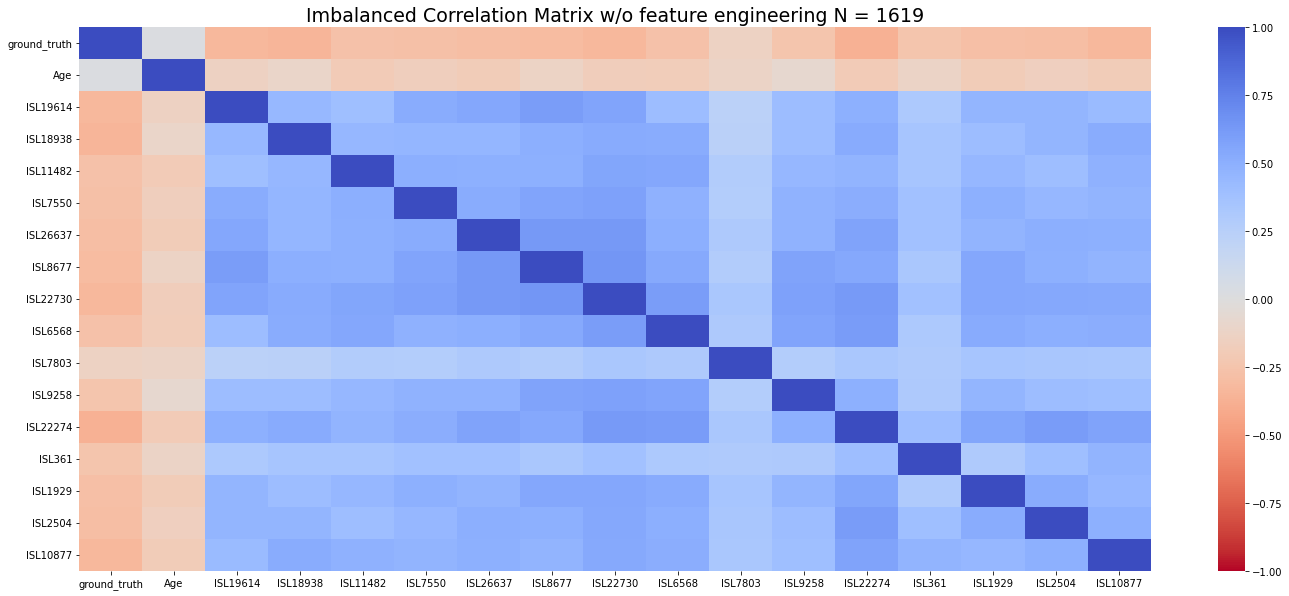

In [ ]:
# plot Entire DataFrame but without feature engineering N = 1619

f, ax1 = plt.subplots(1, 1, figsize=(24,10))

corr = df_bladder_clean.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, vmin=-1, vmax=1)
ax1.set_title("Imbalanced Correlation Matrix w/o feature engineering N = 1619", fontsize=19)


## 6. Boxplots to understand the distribution of features
- The lower our feature value the more likely it will be a cancer

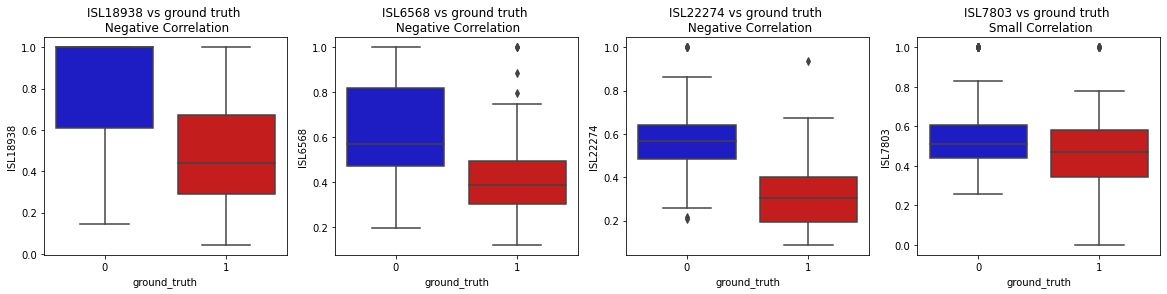

In [ ]:
## box plot to show distributions with respect to categories

f, axes = plt.subplots(ncols=4, figsize=(20,4))
colors = ["#0101DF", "#DF0101"]
# Negative Correlations with our Class (The lower our feature value the more likely it will be a Cancer)
sns.boxplot(x="ground_truth", y="ISL18938", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('ISL18938 vs ground truth \n Negative Correlation')

sns.boxplot(x="ground_truth", y="ISL6568", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('ISL6568 vs ground truth \n Negative Correlation')

sns.boxplot(x="ground_truth", y="ISL22274", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('ISL22274 vs ground truth \n Negative Correlation')

sns.boxplot(x="ground_truth", y="ISL7803", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('ISL7803 vs ground truth \n Small Correlation')

plt.show()

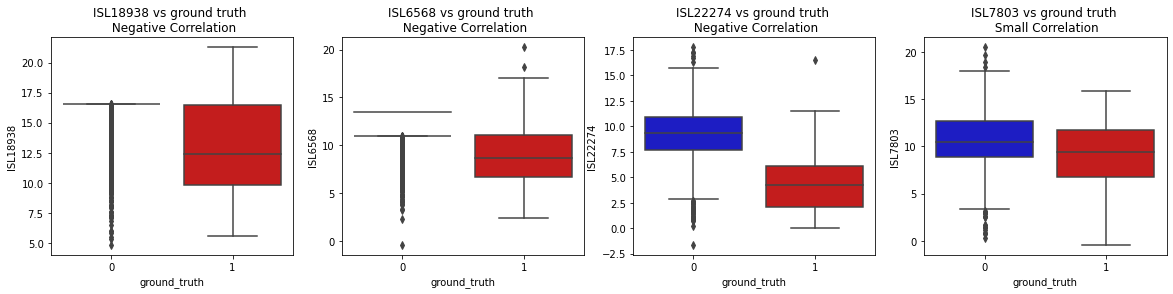

In [ ]:
# Need to remove all rows with inf
# Do the same as above but without feature engineering []
## box plot to show distributions with respect to categories

# f, axes = plt.subplots(ncols=4, figsize=(20,4))
# colors = ["#0101DF", "#DF0101"]
# # Negative Correlations with our Class (The lower our feature value the more likely it will be a Cancer)
# sns.boxplot(x="ground_truth", y="ISL18938", data=df_bladder_clean, palette=colors, ax=axes[0])
# axes[0].set_title('ISL18938 vs ground truth \n Negative Correlation')

# sns.boxplot(x="ground_truth", y="ISL6568", data=df_bladder_clean, palette=colors, ax=axes[1])
# axes[1].set_title('ISL6568 vs ground truth \n Negative Correlation')

# sns.boxplot(x="ground_truth", y="ISL22274", data=df_bladder_clean, palette=colors, ax=axes[2])
# axes[2].set_title('ISL22274 vs ground truth \n Negative Correlation')

# sns.boxplot(x="ground_truth", y="ISL7803", data=df_bladder_clean, palette=colors, ax=axes[3])
# axes[3].set_title('ISL7803 vs ground truth \n Small Correlation')

# plt.show()

## 7. Dimensionality Reduction and Clustering (t-SNE, PCA, SVD):

- t-SNE can cluster the cancer and non-cancer

- Although the subsample is pretty small, the t-SNE algorithm is able to detect clusters in every scenario (I shuffle the dataset before running t-SNE)

- This gives us an indication that further predictive models will perform **well**

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# New_df is from the random undersample data (fewer instances)
X = new_df.drop(['Sample', 'ground_truth', 'Sex', 'Age'], axis=1)
y = new_df['ground_truth']


# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

T-SNE took 3.6 s
PCA took 0.0058 s
Truncated SVD took 0.0032 s


In [ ]:
# variance of the PC1 and PC2

# pca = PCA(n_components=2)
# pca.fit_transform(X.values)
# print(pca.explained_variance_)

# print(pca.explained_variance_ratio_)
# print(pca.singular_values_)

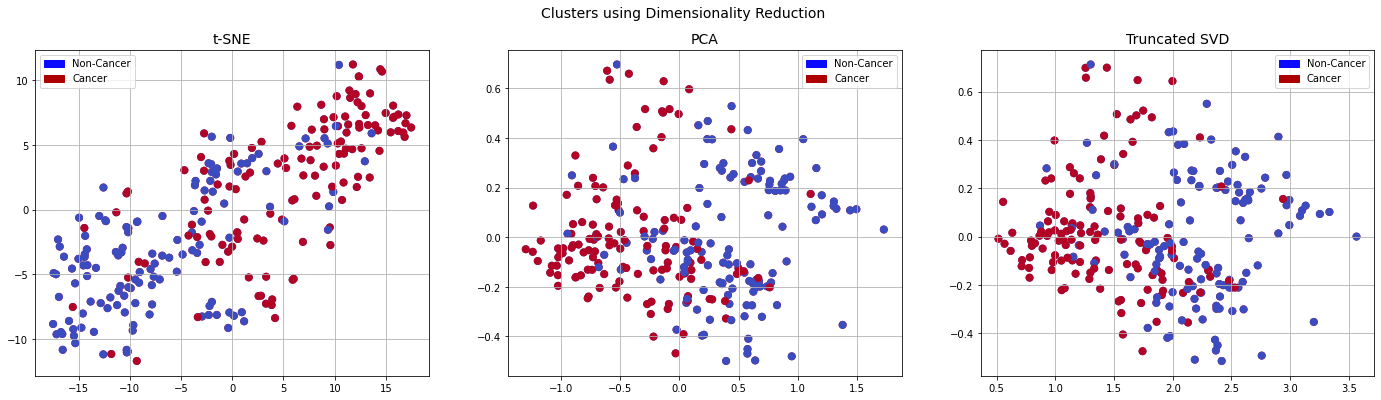

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['Non-Cancer', 'Cancer']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='Non-Cancer')
red_patch = mpatches.Patch(color='#AF0000', label='Cancer')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='Non-Cancer', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Cancer', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='Non-Cancer', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Cancer', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='Non-Cancer', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Cancer', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()

## 8. Classifiers
## A. UnderSampling N =254 dataset):

Train four types of classifiers and decide with ROC score which classifier will be more effective in detecting Cancer.

# Summary:

- Logistic Regression classifier is more accurate than the other three classifiers in most cases, based on Receiving Operating Characteristic score (ROC)

- GridSearchCV is used to determine the paremeters that gives the best predictive score for the classifiers.




In [ ]:
# do later the following classifiers
# import lightgbm as ltb
# from xgboost import XGBRegressor

# New_df is from the random undersample balanced data (fewer instances)


X = new_df.drop(['Sample', 'ground_truth', 'Sex', 'Age'], axis=1)
y = new_df['ground_truth']

# Our data is already scaled we should split our training and test sets
from sklearn.model_selection import train_test_split

# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values


classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}


from sklearn.model_selection import cross_val_score


for key, classifier in classifiers.items():
    #print(classifier)
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a score of", round(training_score.mean(), 2) * 100, "% accuracy score on 5-fold CV")




Classifiers:  LogisticRegression Has a score of 79.0 % accuracy score on 5-fold CV
Classifiers:  KNeighborsClassifier Has a score of 75.0 % accuracy score on 5-fold CV
Classifiers:  SVC Has a score of 81.0 % accuracy score on 5-fold CV
Classifiers:  DecisionTreeClassifier Has a score of 69.0 % accuracy score on 5-fold CV


In [ ]:
# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV


# Logistic Regression
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
#grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params, scoring = 'recall') # for best recall
grid_log_reg.fit(X_train, y_train)
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_


# knears_ niethbor
knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
# grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params, scoring = 'recall') # for best recall
grid_knears.fit(X_train, y_train)
# KNears best estimator
knears_neighbors = grid_knears.best_estimator_



# Support Vector Machine
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
#grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc = GridSearchCV(SVC(), svc_params, scoring = 'recall') # for best recall
grid_svc.fit(X_train, y_train)
# SVC best estimator
svc = grid_svc.best_estimator_


# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)),
              "min_samples_leaf": list(range(5,7,1))}
#grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params, scoring = 'recall') # for best recall
grid_tree.fit(X_train, y_train)

# tree best estimator
tree_clf = grid_tree.best_estimator_

In [ ]:

 # for Logistic Regression
print('Grid best parameter (max. recall): ', grid_log_reg.best_params_)
print('Grid Logistic Regression best score (recall): ', grid_log_reg.best_score_)
grid_log_reg.best_estimator_

 # for knears_ niethbor
print('Grid best parameter (max. recall): ', grid_knears.best_params_)
print('Grid Knn best score (recall): ', grid_knears.best_score_)


 # for SVM
print('Grid best parameter (max. recall): ', grid_svc.best_params_)
print('Grid SVM best score (recall): ', grid_svc.best_score_)

 # for DecisionTree Classifier
print('Grid best parameter (max. recall): ', grid_tree.best_params_)
print('Grid DecisionTree Classifier best score (recall): ', grid_tree.best_score_)



Grid best parameter (max. recall):  {'C': 1, 'penalty': 'l2'}
Grid Logistic Regression best score (recall):  0.8
Grid best parameter (max. recall):  {'algorithm': 'auto', 'n_neighbors': 3}
Grid Knn best score (recall):  0.76
Grid best parameter (max. recall):  {'C': 0.9, 'kernel': 'rbf'}
Grid SVM best score (recall):  0.8099999999999999
Grid best parameter (max. recall):  {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 5}
Grid DecisionTree Classifier best score (recall):  0.8


In [ ]:
# Accuracy after GridSearchCV with the best parameters for Recall

log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')

knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  80.73%
Knears Neighbors Cross Validation Score 75.83%
Support Vector Classifier Cross Validation Score 80.74%
DecisionTree Classifier Cross Validation Score 78.29%


In [ ]:
print("Mean score of %0.2f  with a standard deviation of %0.2f" % (log_reg_score.mean(), log_reg_score.std()))


Mean score of 0.81  with a standard deviation of 0.05


In [ ]:
print(log_reg_score.std())
print(svc_score.std())
print(tree_score.std())
print(knears_score.std())


0.05473015301475451
0.04963938966731686
0.0681062350335574
0.041264948258647065


In [ ]:

##########################################
# Evaluating the model on ALL the test dataset and not only on the undersampled dataset
#####################


undersample_X = df.drop(['Sample', 'ground_truth', 'Sex', 'Age'], axis=1)
undersample_y = df['ground_truth']

for train_index, test_index in sss.split(undersample_X, undersample_y):
    #print("Train:", train_index, "Test:", test_index)
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]

undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values

undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []

# # Implementing NearMiss Technique
# # Distribution of NearMiss (Just to see how it distributes the labels we won't use these variables)
# X_nearmiss, y_nearmiss = NearMiss().fit_sample(undersample_X.values, undersample_y.values)
# print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))

# # Cross Validating the right way

for train, test in sss.split(undersample_Xtrain, undersample_ytrain):

    undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), log_reg) # SMOTE happens during Cross Validation not before..
    undersample_model = undersample_pipeline.fit(undersample_Xtrain[train], undersample_ytrain[train])
    undersample_prediction = undersample_model.predict(undersample_Xtrain[test])

    undersample_accuracy.append(undersample_pipeline.score(original_Xtrain[test], original_ytrain[test]))
    undersample_precision.append(precision_score(original_ytrain[test], undersample_prediction))
    undersample_recall.append(recall_score(original_ytrain[test], undersample_prediction))
    undersample_f1.append(f1_score(original_ytrain[test], undersample_prediction))
    undersample_auc.append(roc_auc_score(original_ytrain[test], undersample_prediction))

# Learning Curves:

- The wider the gap between the training score and the cross validation score, the more likely the model is overfitting (high variance).

- If the score is low in both training and cross-validation sets this is an indication that our model is underfitting (high bias)

- Logistic Regression Classifier shows the best score in both training and cross-validating sets.

In [ ]:
#@title Default title text
# Plot LogisticRegression Learning Curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator1, estimator2, estimator3, estimator4, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(0.1, 1.0, 5) ):
    # np.linspace(.1, 1.0, 5)

    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey=True)



    if ylim is not None:
        plt.ylim(*ylim)

    # First Estimator

    #print(X.shape)

    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("Logistic Regression Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size ')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")

    # Second Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator2, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)

    #print(train_sizes)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax2.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax2.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax2.set_title("Knears Neighbors Learning Curve", fontsize=14)
    ax2.set_xlabel('Training size ')
    ax2.set_ylabel('Score')
    ax2.grid(True)
    ax2.legend(loc="best")

    # Third Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator3, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax3.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax3.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax3.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax3.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax3.set_title("Support Vector Classifier \n Learning Curve", fontsize=14)
    ax3.set_xlabel('Training size ')
    ax3.set_ylabel('Score')
    ax3.grid(True)
    ax3.legend(loc="best")

    # Fourth Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator4, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax4.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax4.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax4.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax4.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax4.set_title("Decision Tree Classifier \n Learning Curve", fontsize=14)
    ax4.set_xlabel('Training size ')
    ax4.set_ylabel('Score')
    ax4.grid(True)
    ax4.legend(loc="best")
    return plt

In [ ]:
#@title Default title text
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(log_reg, knears_neighbors, svc, tree_clf, X_train, y_train, (0.55, 1.01), cv=cv, n_jobs=4)

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
# Create a DataFrame with all the scores and the classifiers names

log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5,
                             method="decision_function")

knears_pred = cross_val_predict(knears_neighbors, X_train, y_train, cv=5)

svc_pred = cross_val_predict(svc, X_train, y_train, cv=5,
                             method="decision_function")

tree_pred = cross_val_predict(tree_clf, X_train, y_train, cv=5)

### Is undersampled model generelizable?



In [ ]:

from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_train, log_reg_pred)

from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

y_pred = log_reg.predict(X_train)


# Here is an example of Performance on X_train  bc train and testing on the same data ('---' * 45)
print('Test generalizability of undersampled model: \n')

print('Performance of undersampled model on training dataset: \n')
# What needs to be here is the cross validated train performance taken on undersampled data set

print('Sensitivity Score: {:.2f}'.format(recall_score(y_train, y_pred)))
print('Specificity Score: {:.2f}'.format(precision_score(y_train, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_train, y_pred)))
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_train, y_pred)))
print('---' * 45)

# When we test the model on all the dataset the performance is bad
print('---' * 45)
print('Cross-Validated performance on all dataset: \n')

print("Sensitivity Score: {:.2f}".format(np.mean(undersample_recall)))
print("Specificity Score: {:.2f}".format(np.mean(undersample_precision)))
print("F1 Score: {:.2f}".format(np.mean(undersample_f1)))
print("Accuracy Score: {:.2f}".format(np.mean(undersample_accuracy)))
print('---' * 45)

Test generalizability of undersampled model: 

Performance on training set of undersampled dataset: 

Sensitivity Score: 0.74
Specificity Score: 0.87
F1 Score: 0.80
Accuracy Score: 0.82
---------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------
Cross-Validated performance on all dataset: 

Sensitivity Score: 0.17
Specificity Score: 0.06
F1 Score: 0.09
Accuracy Score: 0.83
---------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
from sklearn.metrics import roc_auc_score

print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(y_train, knears_pred))
print('Support Vector Classifier: ', roc_auc_score(y_train, svc_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_train, tree_pred))

Logistic Regression:  0.9025242718446602
KNears Neighbors:  0.8268932038834952
Support Vector Classifier:  0.885631067961165
Decision Tree Classifier:  0.7982038834951457


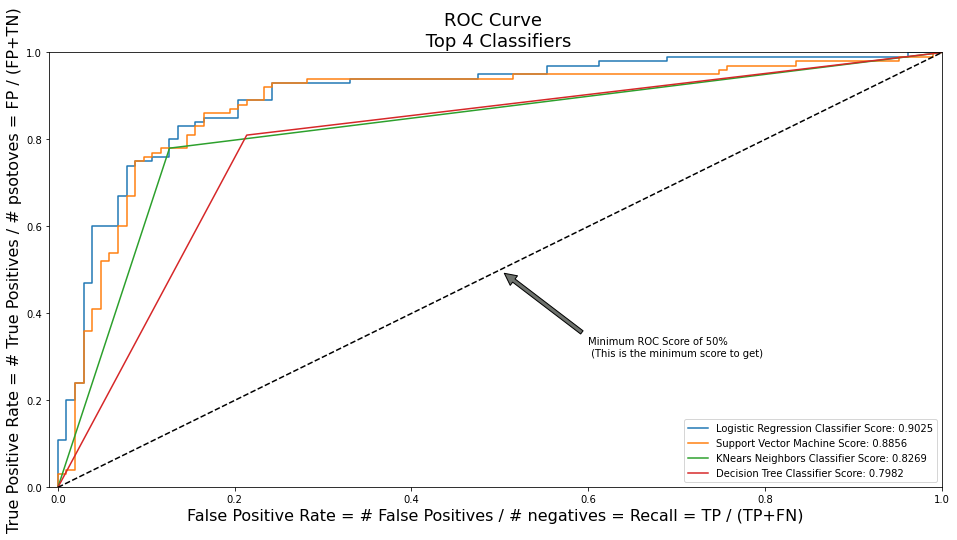

In [ ]:
# Plot the ROC curve

log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred)


def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 4 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Machine Score: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate = # False Positives / # negatives = Recall = TP / (TP+FN)', fontsize=16)
    plt.ylabel('True Positive Rate = # True Positives / # psotoves = FP / (FP+TN)', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()

graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)
plt.show()

## A Deeper Look into LogisticRegression:


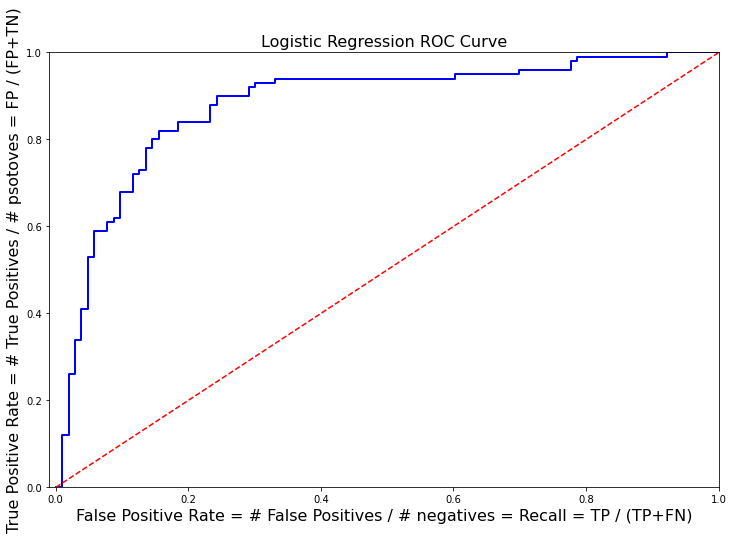

In [ ]:
def logistic_roc_curve(log_fpr, log_tpr):
    plt.figure(figsize=(12,8))
    plt.title('Logistic Regression ROC Curve', fontsize=16)
    plt.plot(log_fpr, log_tpr, 'b-', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate = # False Positives / # negatives = Recall = TP / (TP+FN)', fontsize=16)
    plt.ylabel('True Positive Rate = # True Positives / # psotoves = FP / (FP+TN)', fontsize=16)
    plt.axis([-0.01,1,0,1])


logistic_roc_curve(log_fpr, log_tpr)
plt.show()

In [ ]:
undersample_y_score = log_reg.decision_function(original_Xtest)

from sklearn.metrics import average_precision_score

undersample_average_precision = average_precision_score(original_ytest, undersample_y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      undersample_average_precision))



Average precision-recall score: 0.62


Text(0.5, 1.0, 'UnderSampling Precision-Recall curve: \n Average Precision-Recall Score =0.62')

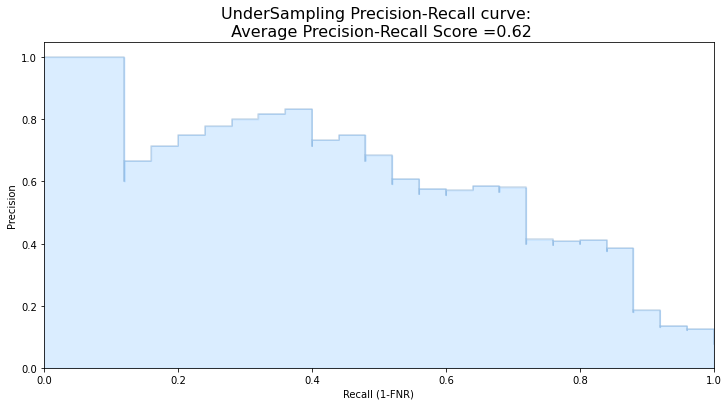

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, undersample_y_score)

plt.step(recall, precision, color='#004a93', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#48a6ff')

plt.xlabel('Recall (1-FNR)')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('UnderSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          undersample_average_precision), fontsize=16)

## SMOTE Technique (Over-Sampling):

SMOTE stands for Synthetic Minority Over-sampling Technique. Unlike Random UnderSampling, SMOTE creates new synthetic points in order to have an equal balance of the classes. This is another alternative for solving the "class imbalance problems".


**Location of the synthetic points:**
SMOTE picks the distance between the closest neighbors of the minority class, in between these distances it creates synthetic points.

**Final Effect:**
More information is retained since we didn't have to delete any rows unlike in random undersampling.

**Accuracy || Time Tradeoff**
Although it is likely that SMOTE will be more accurate than random under-sampling, it will take more time to train.


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV


print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))

# List to append the score and then find the average
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# Classifier with optimal parameters
# log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm = LogisticRegression()

# from the previous no need here
#grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params, scoring = 'recall') # for best recall


# original without optimizing for recall
#rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)

rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4, scoring = 'recall') # for best recall


# Implementing SMOTE Technique
# Cross Validating the right way
# Parameters
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
for train, test in sss.split(original_Xtrain, original_ytrain):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg) # SMOTE happens during Cross Validation not before..
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(original_Xtrain[test])

    accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))

print('---' * 45)
print('Example of classification report on training dataset:')
print('')
labels = ['Non-Cancer', 'Cancer']
smote_prediction_training = best_est.predict(original_Xtrain[test])
print(classification_report(original_ytrain[test], smote_prediction_training, target_names=labels))

print('---' * 45)
print('Performance of cross validation on training dataset:')
print('')
print("Sensitivity: {}".format(np.mean(recall_lst)))
print("Specificity: {}".format(np.mean(precision_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print("Accuracy: {}".format(np.mean(accuracy_lst)))
print('---' * 45)

Length of X (train): 1296 | Length of y (train): 1296
Length of X (test): 323 | Length of y (test): 323
---------------------------------------------------------------------------------------------------------------------------------------
Example of classification report on training dataset:

              precision    recall  f1-score   support

  Non-Cancer       0.98      0.85      0.91       238
      Cancer       0.33      0.81      0.47        21

    accuracy                           0.85       259
   macro avg       0.65      0.83      0.69       259
weighted avg       0.93      0.85      0.88       259

---------------------------------------------------------------------------------------------------------------------------------------
Performance of cross validation on training dataset:

Sensitivity: 0.8433333333333334
Specificity: 0.29246040723981903
f1: 0.4326159255732181
Accuracy: 0.8433333333333334
-----------------------------------------------------------------------

In [ ]:
print('Example of classification report on training dataset:')
print('')
labels = ['Non-Cancer', 'Cancer']
smote_prediction_training = best_est.predict(original_Xtrain[test])
print(classification_report(original_ytrain[test], smote_prediction_training, target_names=labels))

Performance on training dataset:

              precision    recall  f1-score   support

  Non-Cancer       0.99      0.84      0.90       238
      Cancer       0.32      0.86      0.46        21

    accuracy                           0.84       259
   macro avg       0.65      0.85      0.68       259
weighted avg       0.93      0.84      0.87       259



In [ ]:
print('Performance on test dataset:')
print('')
labels = ['Non-Cancer', 'Cancer']
smote_prediction = best_est.predict(original_Xtest)
print(classification_report(original_ytest, smote_prediction, target_names=labels))

Performance on test dataset:

              precision    recall  f1-score   support

  Non-Cancer       0.98      0.87      0.92       298
      Cancer       0.33      0.80      0.47        25

    accuracy                           0.86       323
   macro avg       0.66      0.83      0.70       323
weighted avg       0.93      0.86      0.89       323



In [ ]:
from sklearn.metrics import average_precision_score

y_score = best_est.decision_function(original_Xtest)

average_precision = average_precision_score(original_ytest, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))



Average precision-recall score: 0.52


Text(0.5, 1.0, 'OverSampling Precision-Recall curve: \n Average Precision-Recall Score =0.52')

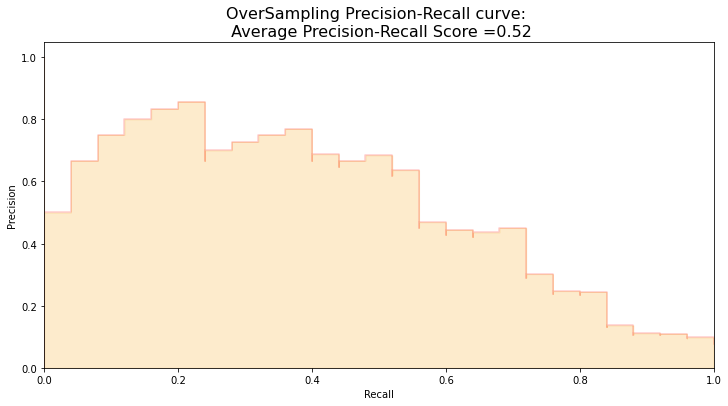

In [ ]:
fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, y_score)

plt.step(recall, precision, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#F59B00')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          average_precision), fontsize=16)

In [ ]:
# SMOTE Technique (OverSampling) After splitting and Cross Validating

sm = SMOTE('minority', random_state=42)

#sm = SMOTE(ratio='minority', random_state=42)
# Xsm_train, ysm_train = sm.fit_sample(X_train, y_train)


# This will be the data were we are going to work
Xsm_train, ysm_train = sm.fit_resample(original_Xtrain, original_ytrain)

In [ ]:
#
# Implement GridSearchCV and the other models.

# Logistic Regression
t0 = time.time()
log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm.fit(Xsm_train, ysm_train)
t1 = time.time()
print("Fitting oversample data took :{} sec".format(t1 - t0))

NameError: ignored

## Test Data with Logistic Regression:

## Confusion Matrix:

Positive/Negative: Type of Class (label) ["No", "Yes"] True/False: Correctly or Incorrectly classified by the model.


True Negatives (Top-Left Square): This is the number of correctly classifications of the "No" (No Cancer Detected) class.


False Negatives (Top-Right Square): This is the number of incorrectly classifications of the "No"(No Cancer Detected) class.


False Positives (Bottom-Left Square): This is the number of incorrectly classifications of the "Yes" (Cancer Detected) class


True Positives (Bottom-Right Square): This is the number of correctly classifications of the "Yes" (Cancer Detected) class.

**Summary:**

**Random UnderSampling**: We will evaluate the final performance of the classification models in the random undersampling subset.
Classification Models: The models that performed the best were Decision Tree and SVM

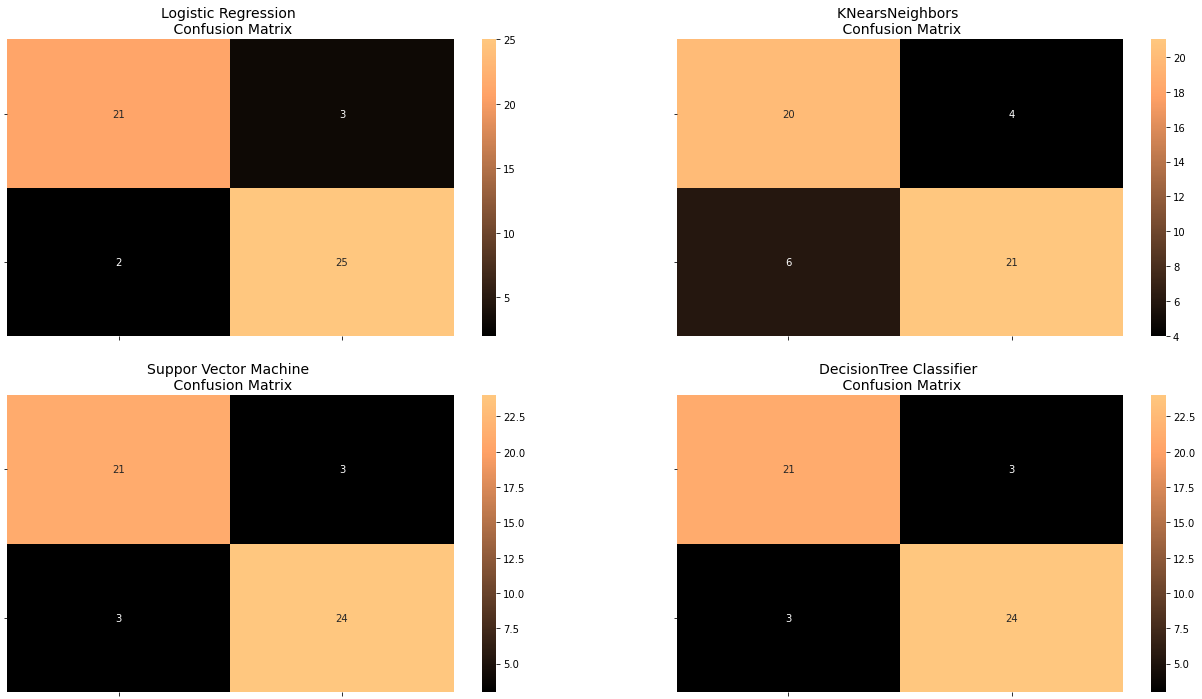

In [ ]:
from sklearn.metrics import confusion_matrix

# Logistic Regression fitted using SMOTE technique
y_pred_log_reg = log_reg_sm.predict(X_test)

# Other models fitted with UnderSampling
y_pred_knear = knears_neighbors.predict(X_test)
y_pred_svc = svc.predict(X_test)
y_pred_tree = tree_clf.predict(X_test)


log_reg_cf = confusion_matrix(y_test, y_pred_log_reg)
kneighbors_cf = confusion_matrix(y_test, y_pred_knear)
svc_cf = confusion_matrix(y_test, y_pred_svc)
tree_cf = confusion_matrix(y_test, y_pred_tree)

fig, ax = plt.subplots(2, 2,figsize=(22,12))


sns.heatmap(log_reg_cf, ax=ax[0][0], annot=True, cmap=plt.cm.copper)
ax[0, 0].set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
ax[0, 0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0, 0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(kneighbors_cf, ax=ax[0][1], annot=True, cmap=plt.cm.copper)
ax[0][1].set_title("KNearsNeighbors \n Confusion Matrix", fontsize=14)
ax[0][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(svc_cf, ax=ax[1][0], annot=True, cmap=plt.cm.copper)
ax[1][0].set_title("Suppor Vector Machine \n Confusion Matrix", fontsize=14)
ax[1][0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(tree_cf, ax=ax[1][1], annot=True, cmap=plt.cm.copper)
ax[1][1].set_title("DecisionTree Classifier \n Confusion Matrix", fontsize=14)
ax[1][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][1].set_yticklabels(['', ''], fontsize=14, rotation=360)


plt.show()

In [ ]:
from sklearn.metrics import classification_report


print('Logistic Regression:')
print(classification_report(y_test, y_pred_log_reg))

print('Support Vector Machine:')
print(classification_report(y_test, y_pred_svc))

print('KNears Neighbors:')
print(classification_report(y_test, y_pred_knear))

print('DecisionTree Classifier:')
print(classification_report(y_test, y_pred_tree))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.91      0.88      0.89        24
           1       0.89      0.93      0.91        27

    accuracy                           0.90        51
   macro avg       0.90      0.90      0.90        51
weighted avg       0.90      0.90      0.90        51

Support Vector Machine:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        24
           1       0.89      0.89      0.89        27

    accuracy                           0.88        51
   macro avg       0.88      0.88      0.88        51
weighted avg       0.88      0.88      0.88        51

KNears Neighbors:
              precision    recall  f1-score   support

           0       0.77      0.83      0.80        24
           1       0.84      0.78      0.81        27

    accuracy                           0.80        51
   macro avg       0.80      0.81      0.80        51
weighted av

In [ ]:
# Final Score in the test set of logistic regression
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score


# Logistic Regression with Under-Sampling
y_pred = log_reg.predict(X_test)
undersample_score = accuracy_score(y_test, y_pred)
undersample_recall_score = recall_score(y_test, y_pred)


# Logistic Regression with SMOTE Technique (Better accuracy with SMOTE t)
y_pred_sm = best_est.predict(original_Xtest)
oversample_score = accuracy_score(original_ytest, y_pred_sm)

oversample_recall_score = recall_score(original_ytest, y_pred_sm)



# d = {'Technique': ['Random UnderSampling', 'Oversampling (SMOTE)'], 'Score': [undersample_score, oversample_score]}
# final_df = pd.DataFrame(data=d)

# # Move column
# score = final_df['Score']
# final_df.drop('Score', axis=1, inplace=True)
# final_df.insert(1, 'Score', score)


#d = {'Technique': ['Random UnderSampling', 'All test dataset'], 'Accuracy': [undersample_score, oversample_score]}

d = {'Technique': ['Random UnderSampling', 'All test dataset'], 'Accuracy': [undersample_score, oversample_score],'Recall': [undersample_recall_score, oversample_recall_score]}

final_df = pd.DataFrame(data=d)

# Move column
score = final_df['Accuracy']
final_df.drop('Accuracy', axis=1, inplace=True)
final_df.insert(1, 'Accuracy', score)

final_df

NameError: ignored

## Neural Networks model with UnderSampling  vs OverSampling (SMOTE) Dataset:

Neural Network with two hidden layers


# Summary (Keras || Random UnderSampling):

**Dataset:** Fit this model in both the undersampled and oversampled dataset (SMOTE).

**Neural Network Structure:**
One input layer (where the number of nodes equals the number of features) plus bias node, one/two hidden layer with 32 nodes and one output node composed of two possible results 0 or 1 (No Cancer or Cancer).

**characteristics:**
The learning rate = 0.001,
the optimizer = AdamOptimizer,
the activation function = "Relu"
for the final outputs use sparse categorical cross entropy, gives the probability whether an instance case is no cancer or cancer (The prediction will pick the highest probability between the two)

In [ ]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from sklearn.metrics import confusion_matrix


n_inputs = X_train.shape[1]

# Make sure to initialize weight with a random seed

undersample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(32, activation="relu"),
    Dense(2, activation='softmax')
    #Dense(1, activation='sigmoid') #instead of softmax
])


undersample_model.summary()

# maybe use loss='binary_cross_entropy'
undersample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = undersample_model.fit(X_train, y_train, validation_split=0.2, batch_size=25, epochs=150, shuffle=True, verbose=2)

undersample_predictions = undersample_model.predict(original_Xtest, batch_size=200, verbose=0)

#undersample_cancer_predictions = undersample_model.predict_classes(original_Xtest, batch_size=200, verbose=0)
undersample_cancer_predictions = np.argmax(undersample_model.predict(original_Xtest, batch_size=200, verbose=0),axis=1)



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 15)                240       
                                                                 
 dense_17 (Dense)            (None, 32)                512       
                                                                 
 dense_18 (Dense)            (None, 32)                1056      
                                                                 
 dense_19 (Dense)            (None, 2)                 66        
                                                                 
Total params: 1,874
Trainable params: 1,874
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
7/7 - 1s - loss: 0.7244 - accuracy: 0.4938 - val_loss: 0.6974 - val_accuracy: 0.4390 - 800ms/epoch - 114ms/step
Epoch 2/150
7/7 - 0s - loss: 0.6864 - accuracy: 0.5988 - val

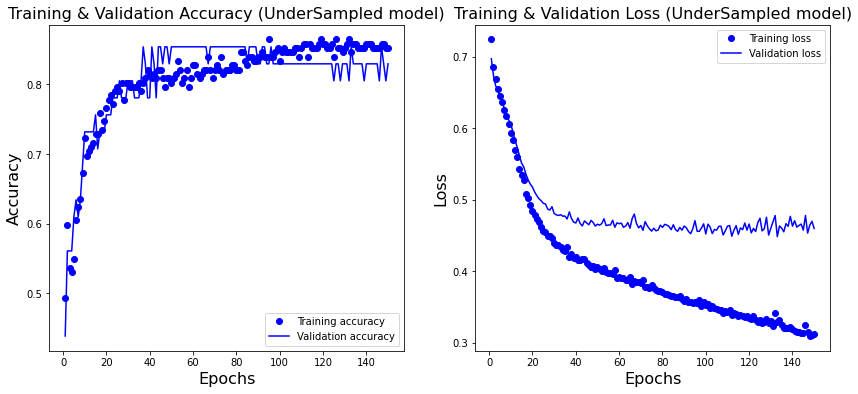

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Plot the model accuracy vs Epochs
#
ax[0].plot(epochs, accuracy, 'bo', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy (UnderSampled model)', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Plot the loss vs Epochs
#
ax[1].plot(epochs, loss_values, 'bo', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title('Training & Validation Loss (UnderSampled model)', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

In [ ]:
print('UnderSampled Performance')

# recall: tp / (tp + fn)
recall = recall_score(original_ytest, undersample_cancer_predictions)
print('Sensitivity: %.2f' % recall)

# precision tp / (tp + fp)
precision = precision_score(original_ytest, undersample_cancer_predictions)
print('Specificity: %.2f' % precision)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(original_ytest, undersample_cancer_predictions)
print('F1 score: %.2f' % f1)

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(original_ytest, undersample_cancer_predictions)
print('Accuracy: %.2f' % accuracy)

auc = roc_auc_score(original_ytest, undersample_cancer_predictions)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(original_ytest, undersample_cancer_predictions)
print("\n Confusion Matrix: \n", matrix)

# print("Sensitivity: {}".format(recall))
# print("Specificity: {}".format(precision))
# print("f1: {}".format(np.mean(f1)))
# print("Accuracy: {}".format(accuracy))

UnderSampled Performance
Sensitivity: 0.88
Specificity: 0.31
F1 score: 0.45
Accuracy: 0.84
ROC AUC: 0.856107

 Confusion Matrix: 
 [[248  50]
 [  3  22]]


In [ ]:
#undersample_cancer_predictions = undersample_model.predict_classes(original_Xtest, batch_size=200, verbose=0)

#undersample_cancer_predictions = (undersample_model.predict(original_Xtest) > 0.5).astype("int32")



# undersample_cancer_predictions = model.predict(X_test)
# classes_x = np.argmax (undersample_cancer_predictions,axis=1)


In [ ]:
import itertools

# Create a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[254  44]
 [  3  22]]
Confusion matrix, without normalization
[[298   0]
 [  0  25]]


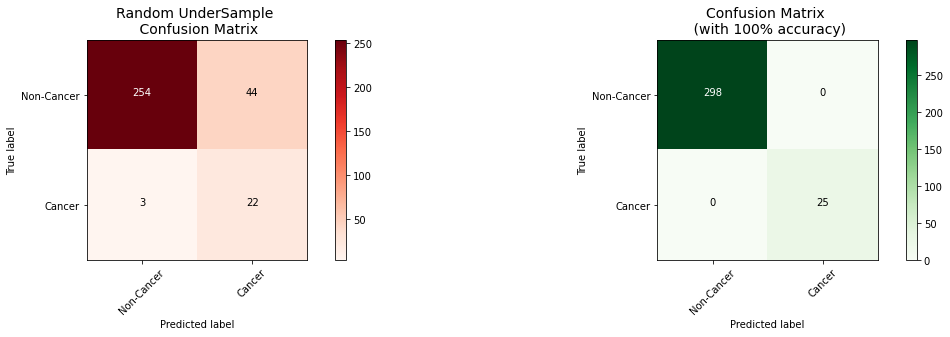

In [ ]:
undersample_cm = confusion_matrix(original_ytest, undersample_cancer_predictions)
actual_cm = confusion_matrix(original_ytest, original_ytest)
labels = ['Non-Cancer', 'Cancer']

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(undersample_cm, labels, title="Random UnderSample \n Confusion Matrix", cmap=plt.cm.Reds)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)

### Keras || OverSampling (SMOTE):


In [ ]:
n_inputs = Xsm_train.shape[1]

oversample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

In [ ]:
oversample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_oversample_model = oversample_model.fit(Xsm_train, ysm_train, validation_split=0.2, batch_size=300, epochs=150, shuffle=True, verbose=2)

oversample_predictions = oversample_model.predict(original_Xtest, batch_size=200, verbose=0)

#oversample_cancer_predictions = oversample_model.predict_classes(original_Xtest, batch_size=200, verbose=0)

#oversample_cancer_predictions = oversample_model.predict_classes(original_Xtest, batch_size=200, verbose=0)

oversample_cancer_predictions = np.argmax(oversample_model.predict(original_Xtest, batch_size=200, verbose=0),axis=1)



Epoch 1/150
7/7 - 1s - loss: 0.1082 - accuracy: 0.9618 - val_loss: 0.3000 - val_accuracy: 0.8954 - 594ms/epoch - 85ms/step
Epoch 2/150
7/7 - 0s - loss: 0.1025 - accuracy: 0.9675 - val_loss: 0.2305 - val_accuracy: 0.9351 - 81ms/epoch - 12ms/step
Epoch 3/150
7/7 - 0s - loss: 0.1017 - accuracy: 0.9670 - val_loss: 0.3181 - val_accuracy: 0.8933 - 88ms/epoch - 13ms/step
Epoch 4/150
7/7 - 0s - loss: 0.1000 - accuracy: 0.9686 - val_loss: 0.2182 - val_accuracy: 0.9351 - 86ms/epoch - 12ms/step
Epoch 5/150
7/7 - 0s - loss: 0.0990 - accuracy: 0.9675 - val_loss: 0.3019 - val_accuracy: 0.9079 - 78ms/epoch - 11ms/step
Epoch 6/150
7/7 - 0s - loss: 0.0999 - accuracy: 0.9681 - val_loss: 0.2631 - val_accuracy: 0.9100 - 83ms/epoch - 12ms/step
Epoch 7/150
7/7 - 0s - loss: 0.0966 - accuracy: 0.9707 - val_loss: 0.2774 - val_accuracy: 0.9121 - 74ms/epoch - 11ms/step
Epoch 8/150
7/7 - 0s - loss: 0.0988 - accuracy: 0.9691 - val_loss: 0.2995 - val_accuracy: 0.9079 - 79ms/epoch - 11ms/step
Epoch 9/150
7/7 - 0s - 

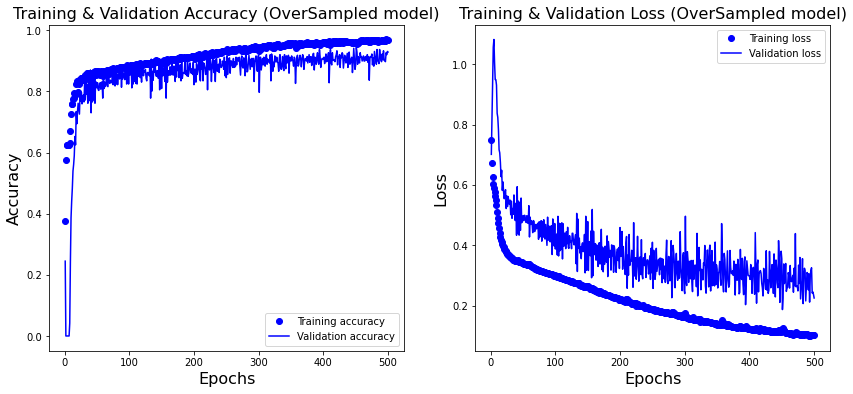

In [ ]:
history_dict = history_oversample_model.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Plot the model accuracy vs Epochs
#
ax[0].plot(epochs, accuracy, 'bo', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy (OverSampled model)', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Plot the loss vs Epochs
#
ax[1].plot(epochs, loss_values, 'bo', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title('Training & Validation Loss (OverSampled model)', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

In [ ]:
# recall: tp / (tp + fn)
recall = recall_score(original_ytest, oversample_cancer_predictions)
print('OverSampled Performance')
print('Sensitivity: %.2f' % recall)

# precision tp / (tp + fp)
precision = precision_score(original_ytest, oversample_cancer_predictions)
print('Specificity: %.2f' % precision)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(original_ytest, oversample_cancer_predictions)
print('F1 score: %.2f' % f1)

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(original_ytest, oversample_cancer_predictions)
print('Accuracy: %.2f' % accuracy)

auc = roc_auc_score(original_ytest, oversample_cancer_predictions)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(original_ytest, oversample_cancer_predictions)
print("\n Confusion Matrix: \n", matrix)

OverSample Performance
Sensitivity: 0.24
Specificity: 0.27
F1 score: 0.26
Accuracy: 0.89
ROC AUC: 0.593154

 Confusion Matrix: 
 [[282  16]
 [ 19   6]]


Confusion matrix, without normalization
[[270  28]
 [ 10  15]]
Confusion matrix, without normalization
[[298   0]
 [  0  25]]


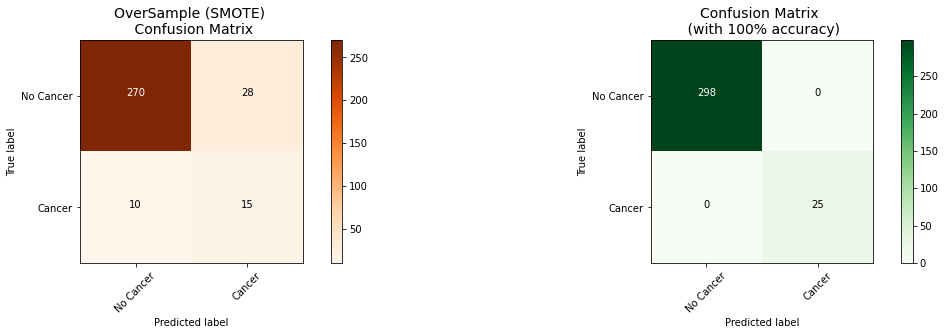

In [ ]:
oversample_smote = confusion_matrix(original_ytest, oversample_cancer_predictions)
actual_cm = confusion_matrix(original_ytest, original_ytest)
labels = ['No Cancer', 'Cancer']

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(oversample_smote, labels, title="OverSample (SMOTE) \n Confusion Matrix", cmap=plt.cm.Oranges)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)

## -----------------------------------------------
## From here and below playing around with different functions and distributions
## -------------------------------------------------

In [ ]:
#
# sns.pairplot(new_df, hue='ground_truth', vars=['Age','ISL19614', 'ISL18938',
#        'ISL11482'])

In [ ]:
#df_normalized.columns

Index(['Sample', 'ground_truth', 'Sex', 'Age', 'ISL19614', 'ISL18938',
       'ISL11482', 'ISL7550', 'ISL26637', 'ISL8677', 'ISL22730', 'ISL6568',
       'ISL7803', 'ISL9258', 'ISL22274', 'ISL361', 'ISL1929', 'ISL2504',
       'ISL10877'],
      dtype='object')

In [ ]:
#PairPlot of all the features:
sns.pairplot(df_bladder.iloc[:, 4:19])

In [ ]:
df_bladder['ground_truth'] = df_bladder['ground_truth'].map({'Negative': 0, 'Positive': 1})
df_bladder.head()

,Sample,ground_truth,Sex,Age,ISL19614,ISL18938,ISL11482,ISL7550,ISL26637,ISL8677,ISL22730,ISL6568,ISL7803,ISL9258,ISL22274,ISL361,ISL1929,ISL2504,ISL10877
0,Am008,0,NaN,NaN,9.300,inf,12.603,12.435,10.521,8.930,8.781,11.849,8.910,9.900,8.643,12.631,11.046,10.143,13.305
1,AM010,0,M,61.0,7.832,18.668,12.121,11.681,11.238,9.017,10.970,17.179,11.412,10.391,8.580,15.324,12.594,11.615,14.771
2,AM014,0,F,84.0,8.487,16.073,inf,11.525,9.398,9.147,9.703,11.161,7.919,9.603,10.972,10.873,11.268,10.822,12.145
3,AM015,0,M,66.0,8.516,inf,13.493,12.405,9.194,10.755,10.835,12.382,10.123,10.794,9.790,inf,11.997,13.039,12.432
4,AM016,0,M,62.0,7.273,13.081,inf,11.439,9.581,7.088,9.616,10.901,7.931,8.468,8.067,10.321,10.673,8.696,9.773


In [ ]:
df_bladder.columns

Index(['Sample', 'ground_truth', 'Sex', 'Age', 'ISL19614', 'ISL18938',
       'ISL11482', 'ISL7550', 'ISL26637', 'ISL8677', 'ISL22730', 'ISL6568',
       'ISL7803', 'ISL9258', 'ISL22274', 'ISL361', 'ISL1929', 'ISL2504',
       'ISL10877'],
      dtype='object')

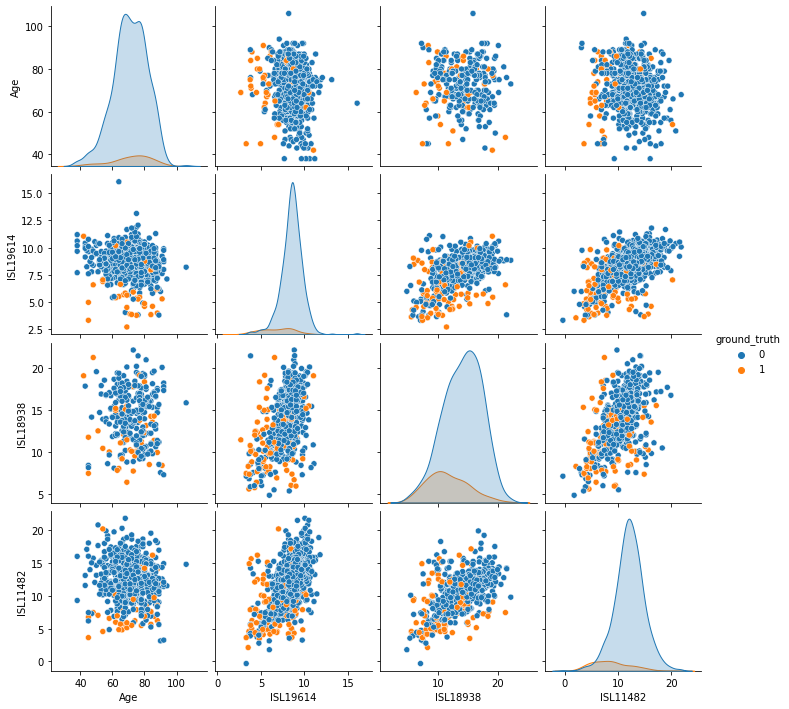

In [ ]:
#@title Use pairplot to understand the best set of features that classify Cancer vs Non-Cancer
# ---PairPlot of all the features with Hue ground_truth to see if the distribution of the cancer and non-cancer are different: ------

sns.pairplot(df_bladder, hue='ground_truth', vars=['Age','ISL19614', 'ISL18938',
       'ISL11482'])

# sns.pairplot(df_bladder, hue='ground_truth', vars=['Age','ISL19614', 'ISL18938',
#        'ISL11482', 'ISL7550', 'ISL26637', 'ISL8677', 'ISL22730', 'ISL6568',
#        'ISL7803'])

# sns.pairplot(df_bladder, hue='ground_truth', vars=['Age','ISL19614', 'ISL18938',
#        'ISL11482', 'ISL7550', 'ISL26637', 'ISL8677', 'ISL22730', 'ISL6568',
#        'ISL7803', 'ISL9258', 'ISL22274', 'ISL361', 'ISL1929', 'ISL2504',
#        'ISL10877'])


0       False
1        True
2       False
3        True
4        True
        ...  
1614    False
1615    False
1616     True
1617    False
1618     True
Name: Sex, Length: 1619, dtype: bool

In [ ]:
#df_bladder[df_bladder['Sex'] == 'M'].shape[0]
df_bladder[df_bladder['Sex'] == 'F'].shape[0]

1249

In [ ]:
ds = df_bladder.isin([np.inf, -np.inf]).sum()
print(ds)

Sample             0
ground_truth       0
Sex                0
Age                0
ISL19614           0
ISL18938        1022
ISL11482         283
ISL7550           77
ISL26637          42
ISL8677           42
ISL22730          65
ISL6568          377
ISL7803          271
ISL9258          104
ISL22274          94
ISL361           556
ISL1929          125
ISL2504          232
ISL10877         572
dtype: int64


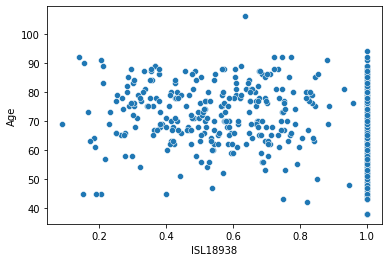

In [ ]:
sns.scatterplot(data=df_bladder, x="ISL18938", y="Age" )
plt.show()

In [ ]:
# Histogram of the age
df_bladder['Age'].hist(bins=40)

In [ ]:
fig, ax = df_bladder['Age'].hist(by=df_bladder['ground_truth'], bins=30)
plt.xlim([25, 110])
plt.ylim([0, 80])
plt.show()

<IPython.core.display.Javascript object>

In [ ]:
fig, ax = df_bladder['Age'].hist(by=df_bladder['Sex'], bins=30)
plt.xlim([25, 110])
plt.ylim([0, 80])
plt.show()

<IPython.core.display.Javascript object>

In [ ]:
# The negative group is x10 larger than the positive group
value_counts_neg_positive = df_bladder['ground_truth'].value_counts(dropna=True, sort=True)
value_counts_neg_positive
#value_counts_neg_positive[1]

Negative    1492
Positive     127
Name: ground_truth, dtype: int64

In [ ]:
df_bladder.head()

,Sample,ground_truth,Sex,Age,ISL19614,ISL18938,ISL11482,ISL7550,ISL26637,ISL8677,ISL22730,ISL6568,ISL7803,ISL9258,ISL22274,ISL361,ISL1929,ISL2504,ISL10877
0,Am008,0,NaN,NaN,9.300,inf,12.603,12.435,10.521,8.930,8.781,11.849,8.910,9.900,8.643,12.631,11.046,10.143,13.305
1,AM010,0,M,61.0,7.832,18.668,12.121,11.681,11.238,9.017,10.970,17.179,11.412,10.391,8.580,15.324,12.594,11.615,14.771
2,AM014,0,F,84.0,8.487,16.073,inf,11.525,9.398,9.147,9.703,11.161,7.919,9.603,10.972,10.873,11.268,10.822,12.145
3,AM015,0,M,66.0,8.516,inf,13.493,12.405,9.194,10.755,10.835,12.382,10.123,10.794,9.790,inf,11.997,13.039,12.432
4,AM016,0,M,62.0,7.273,13.081,inf,11.439,9.581,7.088,9.616,10.901,7.931,8.468,8.067,10.321,10.673,8.696,9.773


In [ ]:
df_bladder[df_bladder['ground_truth']== 0]['Age']

0        NaN
1       61.0
2       84.0
3       66.0
4       62.0
        ... 
1614     NaN
1615     NaN
1616     NaN
1617     NaN
1618     NaN
Name: Age, Length: 1492, dtype: float64

Text(0, 0.5, 'Count')

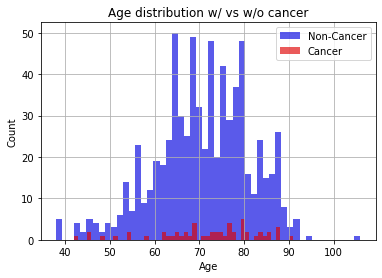

In [ ]:
# Plot histogram without groupby

ax1 = plt.subplot(111)

df_bladder[df_bladder['ground_truth']== 0]['Age'].hist(ax=ax1, bins=50, alpha=0.65, color=colors[0], label='Non-Cancer')
df_bladder[df_bladder['ground_truth']== 1]['Age'].hist(ax=ax1, bins=50, alpha=0.65, color=colors[1], label='Cancer')
ax1.legend(loc='best')

plt.title("Age distribution w/ vs w/o cancer")

plt.xlabel("Age")
plt.ylabel("Count")

Text(0, 0.5, 'Normalized Count')

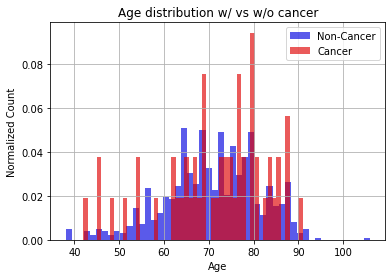

In [ ]:
# No difference in age distribution for the postive and negative cancer groups
#Using groupby to superimpose histograms

ax1 = plt.subplot(111)

df_bladder[df_bladder['ground_truth']== 0]['Age'].hist(ax=ax1, bins=50, alpha=0.65, density=True, color=colors[0], label='Non-Cancer')
df_bladder[df_bladder['ground_truth']== 1]['Age'].hist(ax=ax1, bins=50, alpha=0.65, density=True, color=colors[1], label='Cancer')
ax1.legend(loc='best')

plt.title("Age distribution w/ vs w/o cancer")

plt.xlabel("Age")
plt.ylabel("Normalized Count")

Text(0, 0.5, 'Count')

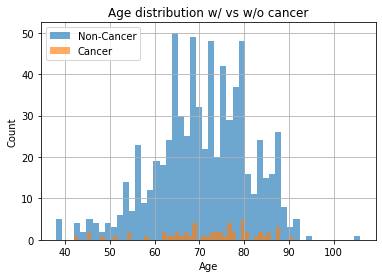

In [ ]:
# the Positive dataset is much smaller
# No difference in age distribution for the postive and negative cancer

#Using groupby to superimpose histograms
df_bladder.groupby('ground_truth')['Age'].hist(bins=50, alpha=0.65)
plt.legend(['Non-Cancer','Cancer' ],loc='upper left')
plt.title("Age distribution w/ vs w/o cancer")

plt.xlabel("Age")
plt.ylabel("Count")

Text(0, 0.5, 'Normalized Count')

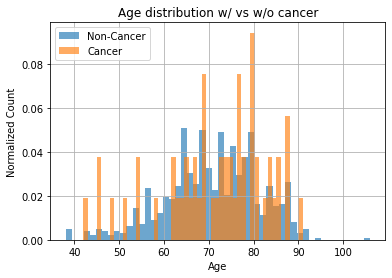

In [ ]:
# No difference in age distribution for the postive and negative cancer groups
#Using groupby to superimpose histograms
df_bladder.groupby('ground_truth')['Age'].hist(bins=50, alpha=0.65, density=True)
plt.legend(['Non-Cancer','Cancer' ],loc='upper left')
plt.title("Age distribution w/ vs w/o cancer")

plt.xlabel("Age")
plt.ylabel("Normalized Count")

Text(0, 0.5, 'Count')

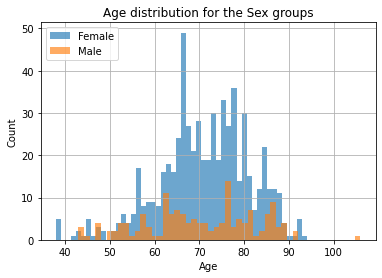

In [ ]:
# No difference in Age distribution for the Sex groups
# Using groupby to superimpose histograms
df_bladder.groupby('Sex')['Age'].hist(bins=50, alpha=0.65)
plt.legend(['Female','Male' ],loc='upper left')
plt.title("Age distribution for the Sex groups")

plt.xlabel("Age")
plt.ylabel("Count")

Text(0, 0.5, 'Normalized Count')

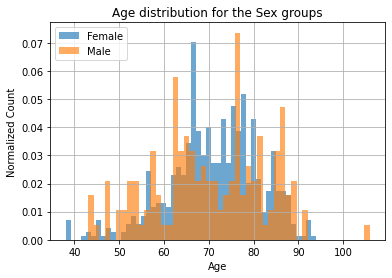

In [ ]:
# No difference in Age distribution for the Sex groups
# Using groupby to superimpose histograms
df_bladder.groupby('Sex')['Age'].hist(bins=50, alpha=0.65, density=True)
plt.legend(['Female','Male' ],loc='upper left')
plt.title("Age distribution for the Sex groups")

plt.xlabel("Age")
plt.ylabel("Normalized Count")

AttributeError: ignored

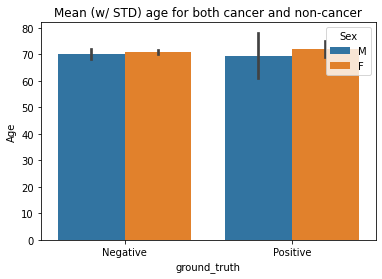

In [ ]:
sns.barplot(x='ground_truth' , y = 'Age' , data = df_bladder, hue='Sex')
plt.title("Mean (w/ STD) age for both cancer and non-cancer")
#plt.palette(['Male','Female' ],loc='right')
# NEED TO CHANGE THE COLOR TO BE THE SAME WITH THE REST OF THE PLOTS

Text(0.5, 1.0, 'Mean (w/ STD) age for both cancer and non-cancer')

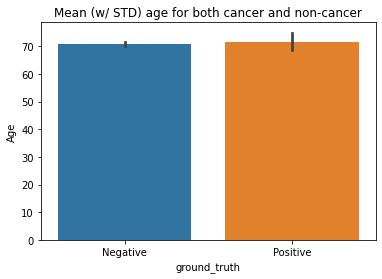

In [ ]:
#sns.barplot(df_bladder, x='ground_truth',y='Age')
sns.barplot(x='ground_truth' , y = 'Age' , data = df_bladder)
plt.title("Mean (w/ STD) age for both cancer and non-cancer")


In [ ]:
value_counts_sex = df_bladder['Sex'].value_counts(dropna=True, sort=True)
value_counts_sex

F    1249
M     354
Name: Sex, dtype: int64

In [ ]:
# Calculate and print the mean and standard deviation of the methylation values for all markers
print("Mean methylation values:")
print(df_bladder.iloc[:, 4:19].mean())
print("Standard deviation of methylation values:")
print(df_bladder.iloc[:, 4:19].std())

Mean methylation values:
ISL19614    8.381935
ISL18938         inf
ISL11482         inf
ISL7550          inf
ISL26637         inf
ISL8677          inf
ISL22730         inf
ISL6568          inf
ISL7803          inf
ISL9258          inf
ISL22274         inf
ISL361           inf
ISL1929          inf
ISL2504          inf
ISL10877         inf
dtype: float64
Standard deviation of methylation values:
ISL19614    1.370882
ISL18938         NaN
ISL11482         NaN
ISL7550          NaN
ISL26637         NaN
ISL8677          NaN
ISL22730         NaN
ISL6568          NaN
ISL7803          NaN
ISL9258          NaN
ISL22274         NaN
ISL361           NaN
ISL1929          NaN
ISL2504          NaN
ISL10877         NaN
dtype: float64
